## Importing necessary libraries

In [1]:
#---general purpose libraries--
import numpy as np
import pandas as pd
import os
#--for text processing----
import nltk
from nltk.corpus import stopwords
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import re
#---for pipelining-----
from sklearn.pipeline import Pipeline

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
#ps = nltk.PorterStemmer()

## Gather the data

In [8]:
#--- Change working directory(where you have corpus)----# 
wrk_dir = input(prompt='Please give the working directory: ')
os.chdir(wrk_dir)
#---- Input filename which contains shakespear's sonnets----
file_name = input(prompt='Please enter sonnet filename: ') #Shakespeare_Sonnets.txt
#----call function to build the sonnet dataframe
df_sonnet = build_sonnet_dataframe(file_name)
df_sonnet.head()

Please give the working directory: D:\Internshala\Socio
Please enter sonnet filename: Shakespeare_Sonnets.txt


,Sonnet
0,"From fairest creatures we desire increase, Tha..."
1,"When forty winters shall besiege thy brow, And..."
2,Look in thy glass and tell the face thou viewe...
3,"Unthrifty loveliness why dost thou spend, Upon..."
4,Those hours that with gentle work did frame Th...


## Exploratory data analysis

(-0.5, 499.5, 499.5, -0.5)

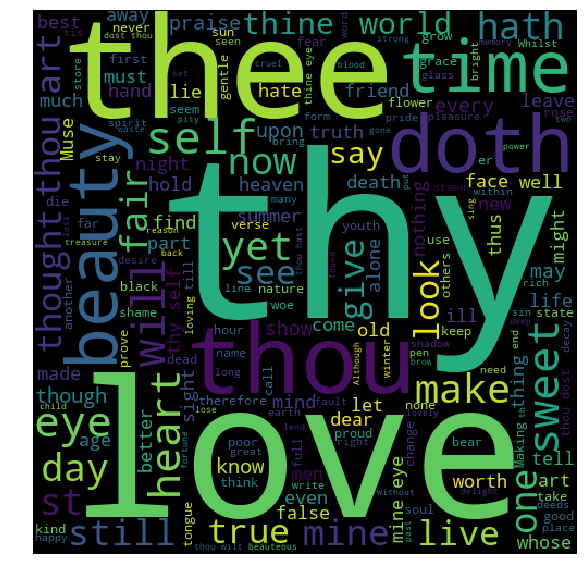

In [39]:
#---- Explore what are the most common words accross entire corpus----
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
wordcloud= WordCloud(width=500, height=500,stopwords=None,background_color='black').generate(''.join(df_sonnet['Sonnet']))
WordCloud()
plt.figure(figsize = (15, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')

In [ ]:
#--- seems like 'thou', 'thee', 'thy' are very common. I would not use these words as the title of my sonnets, even if their frequency is high. So, will remove few commonly occuring words while preprocessing

## Some general purpose functions

In [7]:
#-----------------------FUNCTIONS--------------------------------#

#----------------------------------------------------------------------------
#--- function to extract sonnets from the textfile and store in a dataframe--
#----------------------------------------------------------------------------
def build_sonnet_dataframe(file_name):    
    corpus = open(file_name, encoding='utf-8')
    lines = corpus.readlines()
    sonnets =[]
    paragraph = ''
    for line in lines:
        if line.isspace():
            if paragraph:
                sonnets.append(paragraph.strip())
                paragraph = ''
            continue
        else:
            if line.strip().isnumeric():
                continue
            else:
                paragraph += ' ' + line.strip()
    sonnets.remove(sonnets[0]) #--Remove heading---
    df = pd.DataFrame(data =sonnets, columns = ['Sonnet'] )
    return df

#----------------------------------------------------------------------------
#--- function to remove punctuation marks from a word--
#----------------------------------------------------------------------------
def remove_punctuation(word):
        punc_free= ''.join(ch for ch in word if ch not in string.punctuation)
        return punc_free

#----------------------------------------------------------------------------
#--- function to clean the corpus--
#----------------------------------------------------------------------------
def remove_common_n_stopwords(text):
    common = ['thy','thou','thee','shall','might']
    #Note: instead of using hardcoded common words, we can use 'Part of Speech tags from nltk to remove words like 'might'
    #however, for simplicity, I have just hardcoded the common words here.
    sen = ''
    for word in text.split():
        x= remove_punctuation(word)
        if x not in stopwords:
            if x not in common:
                sen+= ' ' + x
            else:
                continue
        else:
            continue  
    return sen.strip()
#--------------------------------------------------------------------------

In [9]:
df_sonnet['Sonnet'][0]

'From fairest creatures we desire increase, That thereby beauty’s rose might never die, But as the riper should by time decease, His tender heir might bear his memory: But thou contracted to thine own bright eyes, Feed’st thy light’s flame with self-substantial fuel, Making a famine where abundance lies, Thy self thy foe, to thy sweet self too cruel: Thou that art now the world’s fresh ornament, And only herald to the gaudy spring, Within thine own bud buriest thy content, And, tender churl, mak’st waste in niggarding: Pity the world, or else this glutton be, To eat the world’s due, by the grave and thee.'

## finding the most important, frequent word in each sonnet. Let it be 'Title'

In [10]:
#-----preprocess text data by removing stopwords,punctuation marks
df_sonnet['Sonnet_processed'] = df_sonnet['Sonnet'].apply(lambda x: remove_common_n_stopwords(x.lower()))

In [11]:
#----function to give the most important, frquent word in a sonnet----
def word_frequency_count(vec_obj,txt):
    vec = vec_obj.fit(txt)
    bag_of_words = vec.transform(txt)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [12]:
#-----call function word_frequency_count() for all the sonnets and store the result in 'Title' column
df_sonnet['Title']=''
for index, row in df_sonnet.iterrows():
    words_freq=word_frequency_count(TfidfVectorizer(),row['Sonnet_processed'].split())
    #print(words_freq[0][0].upper())
    row['Title']=words_freq[0][0].upper()
df_sonnet.drop(columns=['Sonnet_processed'],inplace=True)
df_sonnet.head()

,Sonnet,Title
0,"From fairest creatures we desire increase, Tha...",WORLD
1,"When forty winters shall besiege thy brow, And...",BEAUTY
2,Look in thy glass and tell the face thou viewe...,GLASS
3,"Unthrifty loveliness why dost thou spend, Upon...",DOST
4,Those hours that with gentle work did frame Th...,BEAUTY


## building sonnet recommender system 

In [13]:
#---extracting keywords from all the sonnets in the dataframe
#--------------------------------------------------------------
df_sonnet['Keywords'] =''
for index, row in df_sonnet.iterrows():
    sonnet = row['Sonnet']    
    #instantiate rake. This will remove all english stopwords and punctuation marks
    #--This could have been done using 'Sonnet_processed' column calculate above. 
    #--However, I found better results by using Rake(). It also de-duplicates words
    rk= Rake()
    rk.extract_keywords_from_text(sonnet)
    keywords_scores = rk.get_word_degrees()  
    # assigning the keywords to the new column for the corresponding sonnet
    Keywords= list(keywords_scores.keys())
    kywrd_clubbed=''
    for words in Keywords:
        kywrd_clubbed = kywrd_clubbed + ''.join(words)+ ' '
    row['Keywords'] = kywrd_clubbed
#-----------------------------------------------------------

In [14]:
#-----generate the count matrix---------
vec= CountVectorizer()
vec_matx=vec.fit_transform(df_sonnet['Keywords'])

#----- generating the cosine similarity matrix
cosine_sim = cosine_similarity(vec_matx, vec_matx)

In [25]:
#-- function to recommend 'n' number of sonnets based on an input sonnet
def sonnet_recommendation(choice,snt,n):
    if choice == '1':
        indx=pd.to_numeric(choice)-1
    else:
        indx = df_sonnet[df_sonnet['Sonnet']==snt].index[0]
    recmnd_indx = list(pd.Series(cosine_sim[indx]).sort_values(ascending = False).index[:n])
    sonnet_recommendation = []
    print('Your recommended Shakespear sonnets are: ')
    for i in recmnd_indx:
        sonnet_recommendation.append(df_sonnet[df_sonnet['Sonnet'].index == i]['Sonnet'])
        print(df_sonnet[df_sonnet['Sonnet'].index == i]['Sonnet'])

In [121]:
#snt = '''From fairest creatures we desire increase, That thereby beautyâ€™s rose might never die, But as the riper should by time decease, His tender heir might bear his memory: But thou contracted to thine own bright eyes, Feedâ€™st thy lightâ€™s flame with self-substantial fuel, Making a famine where abundance lies, Thy self thy foe, to thy sweet self too cruel: Thou that art now the worldâ€™s fresh ornament, And only herald to the gaudy spring, Within thine own bud buriest thy content, And, tender churl, makâ€™st waste in niggarding: Pity the world, or else this glutton be, To eat the worldâ€™s due, by the grave and thee.'''

In [26]:
#--- Ask the input from the user----
#num_of_rec = input('Please enter the number of recommendations you want(number between 1- 10): ')
choice = input('''Please enter the choice of selection: 
            Enter 1 for using sonnet number as input.
            Enter 2 for using sonnet text as input
            ''')
if choice not in ['1','2']:
    print(' Invalid Selection') 
else:
    if choice == '1':
        snt=input('''Please sonnet number from the list: ''')
    else:
        snt=input('''Please sonnet text: ''')
#----The result will be 5(this number can be configurable too) recommended sonnets which are most similar to the input.
sonnet_recommendation(choice,snt,5)

Please enter the choice of selection: 
            Enter 1 for using sonnet number as input.
            Enter 2 for using sonnet text as input
            1
Please sonnet number from the list: 1
Your recommended Shakespear sonnets are: 
0    From fairest creatures we desire increase, Tha...
Name: Sonnet, dtype: object
21    My glass shall not persuade me I am old, So lo...
Name: Sonnet, dtype: object
139    Be wise as thou art cruel, do not press My ton...
Name: Sonnet, dtype: object
2    Look in thy glass and tell the face thou viewe...
Name: Sonnet, dtype: object
9    For shame deny that thou bear’st love to any W...
Name: Sonnet, dtype: object
